In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import math
import re
from pandas.core.frame import DataFrame
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings("ignore")

# 1 Data Loader

In [49]:
categories=pd.read_csv("../datasets/item_categories.csv")
items=pd.read_csv("../datasets/items.csv")
submission=pd.read_csv("../datasets/sample_submission.csv")
shops=pd.read_csv("../datasets/shops.csv")
test=pd.read_csv("../datasets/test.csv")
train=pd.read_csv("../datasets/sales_train.csv")

In [44]:
# # Initialize plot style
# sns.set(style='darkgrid')

# 2 Exploratory Data Analysis

## 2.1  Overview of data

In [29]:
# Basic statistics of item sales price and item sale
train[["item_price", "item_cnt_day"]].describe().applymap('{:,.2f}'.format)

,item_price,item_cnt_day
count,"2,935,849.00","2,935,849.00"
mean,890.85,1.24
std,"1,729.80",2.62
min,-1.00,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,"307,980.00","2,169.00"


In [30]:
categories = categories.astype("category")
categories.describe(include = "all")

,item_category_name,item_category_id
count,84,84
unique,84,84
top,PC - Гарнитуры/Наушники,0
freq,1,1


In [31]:
items = items.astype("category")
items.describe(include = "all")

,item_name,item_id,item_category_id
count,22170,22170,22170
unique,22170,22170,84
top,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
freq,1,1,5035


In [32]:
shops = shops.astype("category")
shops.describe(include = "all")

,shop_name,shop_id
count,60,60
unique,60,60
top,"!Якутск Орджоникидзе, 56 фран",0
freq,1,1


## 2.2 Correlations of variables

## 2.3 Check overall sales status

In [39]:
# Calculate the total sales per shop
sales_per_shop = pd.DataFrame(train.groupby(["shop_id"])["item_cnt_day"].sum())
sales_per_shop = sales_per_shop.reset_index()
# Calculate the most profitable product
train["profit"] = (train["item_price"]*train["item_cnt_day"])/1000
profit_per_shop = pd.DataFrame(train.groupby("shop_id")["profit"].sum())
profit_per_shop = profit_per_shop.reset_index()

The Number of Items Sold Monthly Between 2013 and 2015

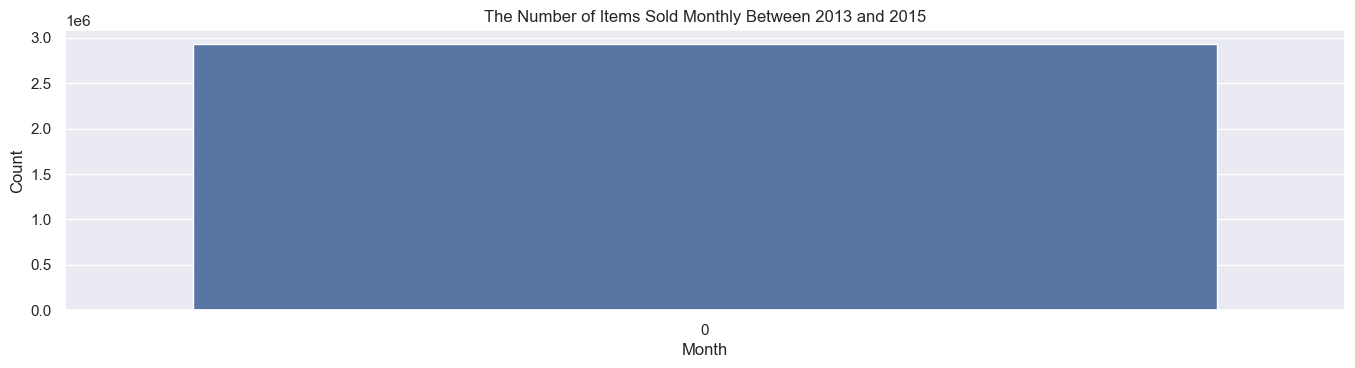

In [35]:
plt.rcParams['figure.figsize'] = (16, 4)
sns.countplot(train['date_block_num'])
plt.title('The Number of Items Sold Monthly Between 2013 and 2015', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.savefig('./drive/MyDrive/ADM_Assignment2/Monthly_Sales.png', dpi=100)

plt.show()

The Total Profit per Shop Between 2013 and 2015

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
plt.subplot(211)
sns.barplot(shops['shop_id'], sales_per_shop["item_cnt_day"])
plt.title('The Number of Items Sold per Shop', fontsize = 14)
plt.xlabel('Shop Id', fontsize = 11)
plt.ylabel('Count', fontsize = 11)

plt.subplot(212)
sns.barplot(profit_per_shop["shop_id"], profit_per_shop["profit"])
plt.title('The Total Profit per Shop Between 2013 and 2015', fontsize = 14)
plt.xlabel('Shop Id', fontsize = 11)
plt.ylabel('The Total Profit (x1000)', fontsize = 11)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.6,
                    hspace=0.6)
plt.savefig('./drive/MyDrive/ADM_Assignment2/Sold_Items_and_Profit.png', dpi=100)
plt.show()

## 2.4 Trend detection

# 3 Data Preprocessing

## 3.1 Detect outliers

In [36]:
# Calculate the sales of items
total_sales_per_day_item = pd.DataFrame(train.groupby("item_id")["item_cnt_day"].max())
total_sales_per_day_item = total_sales_per_day_item.reset_index()
highest_sales_per_day_30item = total_sales_per_day_item.nlargest(30,'item_cnt_day')

In [38]:
plt.rcParams['figure.figsize'] = (16, 4)
sns.barplot(highest_sales_per_day_30item["item_id"], highest_sales_per_day_30item["item_cnt_day"])
plt.title('The Top 30 Items with the Highest Daily Sales', fontsize = 12)
plt.xlabel('Item Id', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation=45)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.savefig('./drive/MyDrive/ADM_Assignment2/Highest_Daily_Sales.png', dpi=100)
plt.show()

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day          2169.0
profit                 1.971
Name: 2909818, dtype: object
                                  item_name item_id item_category_id
11373  Доставка до пункта выдачи (Boxberry)   11373                9


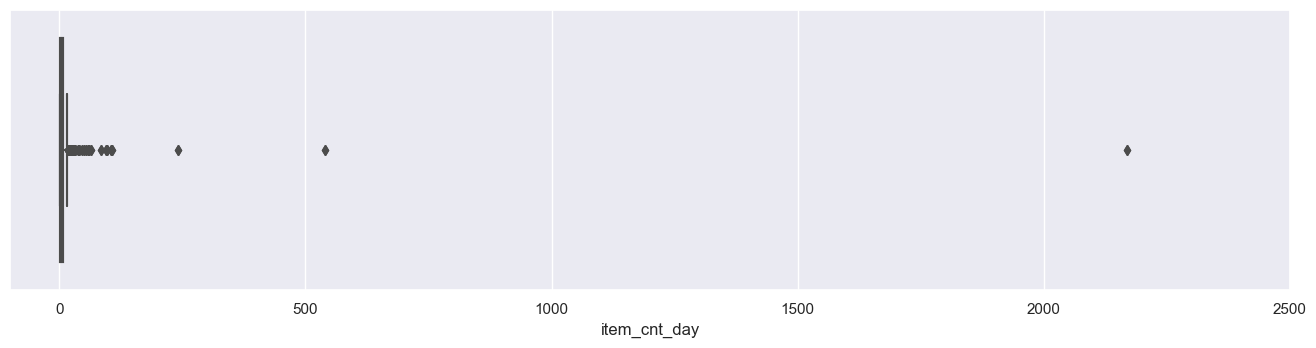

In [41]:
# First outlier's information
print(train.loc[2909818])
print(items[items['item_id'] == 11373]) # item name (Delivery to the point of issue (Boxberry))
# All item 11373 sales
sort_item_11373 = train[train['item_id'] == 11373]['item_cnt_day']
plt.xlim(-100, 2500)
sns.boxplot(x=train[train["item_id"]== 11373]["item_cnt_day"], saturation = 1, color = "red")
plt.xlabel('Daily sales amount', fontsize = 12)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
sns.boxplot(x=sort_item_11373)
plt.savefig('../fig/'+'item_outlier.jpg')

In [42]:
# Second outlier's information
print(train.loc[1163158])
print(items[items['item_id'] == 6066]) # item name (Delivery to the point of issue (Boxberry))
# how many sales
train[train['item_id'] == 6066] # only sale once

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
profit                307.98
Name: 1163158, dtype: object
                 item_name item_id item_category_id
6066  Radmin 3  - 522 лиц.    6066               75


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,profit
1163158,13.12.2013,11,12,6066,307980.0,1.0,307.98


## 2.2 Detect missing values

In [43]:
print(train.isnull().any())
print(shops.isnull().any())
print(items.isnull().any())
print(categories.isnull().any())
print(submission.isnull().any())

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
profit            False
dtype: bool
shop_name    False
shop_id      False
dtype: bool
item_name           False
item_id             False
item_category_id    False
dtype: bool
item_category_name    False
item_category_id      False
dtype: bool
ID                False
item_cnt_month    False
dtype: bool


## 3.3 Detect measurement errors

In [45]:
train[train["item_price"] < 0] # only one

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,profit
484683,15.05.2013,4,32,2973,-1.0,1.0,-0.001


In [46]:
# Calculate the expensive items
average_price_per_item = pd.DataFrame(train.groupby("item_id")["item_price"].mean())
average_price_per_item = average_price_per_item.reset_index()
highest_price_30item = average_price_per_item.nlargest(30,'item_price')

In [ ]:
plt.rcParams['figure.figsize'] = (16, 4)
sns.barplot(highest_price_30item["item_id"], highest_price_30item["item_price"])
plt.title('The First 30 Expensive Items', fontsize = 12)
plt.xlabel('Item Id', fontsize = 12)
plt.ylabel('The Price of Items', fontsize = 12)
plt.xticks(rotation=45)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
                    
plt.savefig('./drive/MyDrive/ADM_Assignment2/Expensive_Items.png', dpi=100)
plt.show()

## 3.4 Recoding data

join the city_id and categories_id

In [50]:
# join the item_categories_id
train = train.join(items.set_index('item_id'), on='item_id').drop(columns=['item_name'])

# join the city_id
city = DataFrame.copy(shops)
reg = "\s"
for i in range(len(city['shop_name'])):
    shopName = city['shop_name'][i]
    index = re.search(reg, shopName).span()[0]
    city['shop_name'][i] = shopName[:index]
city.columns = ["city_name", "shop_id"]
city.loc[city['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
city_id = city['city_name'].drop_duplicates().reset_index(drop=True)
for i in range(len(city_id)):
    city.loc[city['city_name'] == city_id[i], 'city_id'] = int(i)
train = train.join(city.set_index('shop_id'), on='shop_id').drop(columns=['city_name'])

# drop outliers and errro value
train = train[train['item_cnt_day'] < 2000]
train = train[train['item_price'] < 300000]
train = train[train['item_price'] > 0]

match the shops

In [51]:
monthly_shop_sales=train.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
monthly_shop_sales=monthly_shop_sales.unstack(level=1).fillna(0)
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

print(list(shops[shops['shop_id']==0]['shop_name']), list(shops[shops['shop_id']==57]['shop_name']))
print(list(shops[shops['shop_id']==1]['shop_name']), list(shops[shops['shop_id']==58]['shop_name']))
print(list(shops[shops['shop_id']==10]['shop_name']), list(shops[shops['shop_id']==11]['shop_name']))
pd.DataFrame(monthly_shop_sales, columns=[0,57,1,58,10,11])

['!Якутск Орджоникидзе, 56 фран'] ['Якутск Орджоникидзе, 56']
['!Якутск ТЦ "Центральный" фран'] ['Якутск ТЦ "Центральный"']
['Жуковский ул. Чкалова 39м?'] ['Жуковский ул. Чкалова 39м²']


,0,57,1,58,10,11
date_block_num,,,,,,
0,5578.0,0.0,2947.0,0.0,935.0,0.0
1,6127.0,0.0,3364.0,0.0,1026.0,0.0
2,0.0,6586.0,0.0,3773.0,1017.0,0.0
3,0.0,5493.0,0.0,2831.0,756.0,0.0
4,0.0,5233.0,0.0,2308.0,683.0,0.0
5,0.0,5987.0,0.0,2972.0,764.0,0.0
6,0.0,5827.0,0.0,3122.0,800.0,0.0
7,0.0,5413.0,0.0,2863.0,755.0,0.0
8,0.0,5213.0,0.0,2735.0,1027.0,0.0


Groupby training set

In [52]:
train = train.drop(columns='date')
train = train.groupby(['date_block_num','shop_id','item_id','item_category_id', 'city_id'])["date_block_num","shop_id", "item_id","item_category_id", "city_id", "item_price","item_cnt_day"].agg({'item_price':sum, 'item_cnt_day':sum})
train.to_csv('../datasets/train_groupby.csv')
train_groupby=pd.read_csv("../datasets/train_groupby.csv")

In [53]:
# finial training set
train_groupby

,date_block_num,shop_id,item_id,item_category_id,city_id,item_price,item_cnt_day
0,0,2,27,19,1.0,2499.0,1.0
1,0,2,33,37,1.0,499.0,1.0
2,0,2,317,45,1.0,299.0,1.0
3,0,2,438,45,1.0,299.0,1.0
4,0,2,471,49,1.0,798.0,2.0
...,...,...,...,...,...,...,...
1609118,33,59,22087,83,30.0,357.0,6.0
1609119,33,59,22088,83,30.0,238.0,2.0
1609120,33,59,22091,83,30.0,179.0,1.0
1609121,33,59,22100,42,30.0,629.0,1.0


---